In [206]:
import numpy as np
from scipy.linalg import expm
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
from functions import kron_commutator,sk_kron,row_to_col,stat_aver,kron_anticom

In [367]:



# Define the time-dependent matrix A(t)
# Parameters
fac = 1000
invf= 1/fac

dw = 2*np.pi*5*fac
w0 = 2*np.pi*100*1000*fac*1.3
w = w0 + dw
sig= w +w0
tau_c = 1e-6*invf


I_x = np.array([[0, 1], [1, 0]]) / 2
I_y = np.array([[0, -1j], [1j, 0]]) / 2
I_z = np.array([[1, 0], [0, -1]]) / 2 

idm = np.eye(I_x.ndim)
# Ladder operators
I_plus = np.array([[0, 1], [0, 0]])
I_minus = np.array([[0, 0], [1, 0]])


def gamma(theta,a):
    if a ==1:
        return (tau_c + 1j*(theta)*tau_c*tau_c )/(1 + ((tau_c*theta)**2)) 
    if a==2:
        return  (tau_c - 1j*(theta)*(tau_c**2) )/(1 + ((tau_c*theta)**2)) 

def expo(a, t):
    return np.exp(1j * a * t)

def fidelity(p,fp):
    sq_p = sqrtm(p)
    return np.real((np.trace(sqrtm(sq_p @ fp @ sq_p)))**2)


I_kron_pl = kron_commutator(I_plus,idm)
I_kron_mi = kron_commutator(I_minus,idm)
I_kr_anti_plmi =kron_anticom(I_plus @ I_minus,idm)
I_kr_anti_mipl =kron_anticom(I_minus @ I_plus,idm)
pl_mi_I = I_kron_pl @ I_kron_mi
mi_pl_I = I_kron_mi @ I_kron_pl
pl_pl_I = I_kron_pl @ I_kron_pl
mi_mi_I = I_kron_mi @ I_kron_mi 
p_plus = 0.6 
p_minus = 0.4
jw = 10000
gamma_sig= gamma(sig,1)
gamma_sigs = gamma(sig,2)
gamma_dw = gamma(dw,1)
gamma_dws = gamma(dw,2)

def liouvilian(w1,t):
    # First order drive term 
    c = ((w1)**2)/4
    F =expo(-dw,t) *kron_commutator(I_plus,idm) +expo(dw,t)*kron_commutator(I_minus,idm)
    L1 = -1j*(w1/2)*F

    # Second order drive term 
    L2 = -c*(gamma_sig*(pl_mi_I) + gamma_sigs* (mi_pl_I) )
    L3 = -(4*c)* (gamma_dw*(pl_pl_I )* expo(-2*dw,t) + gamma_dws*(mi_mi_I)*expo(2*dw,t))
    L4 = -(4*c)* (gamma_dws*pl_mi_I +gamma_dw* mi_pl_I)

    # Second order Coupling Terms
    L5 = -(p_plus*jw*((I_kr_anti_plmi/2) - sk_kron(I_minus,I_plus)))
    L6 = -(p_minus*jw*((I_kr_anti_mipl/2) - sk_kron(I_plus,I_minus)))

    L = L1+L2+L3+L4+L5 + L6


    return L

k= 1000
from joblib import Parallel, delayed

def fidelity_cal_parallel(w1_l, f, rho_f, rho_0):
    def compute_fidelity(w1):
        t_start = 0.0 * invf
        t_stop = ((1.5*np.pi )/ w1)
        
        ts = np.linspace(t_start, t_stop, k)
        h = ts[1]-ts[0]
        if h < tau_c*10:
            h = tau_c*10
            ts = np.arange(t_start,t_stop,h)

        
        fx = np.zeros(len(ts))
        p = rho_0.copy()
        
        for i, t in enumerate(ts):
            f_w1_t = f(w1, t) * h
            exp_f_w1_t = expm(f_w1_t)
            p = np.einsum('ij,jk->ik', exp_f_w1_t, p)
            z = np.squeeze(p.reshape(-1, 2, 2))
            fx[i] = fidelity(z, rho_f)
        return max(fx)
    
    fidelity_m = Parallel(n_jobs=-1)(delayed(compute_fidelity)(w1) for w1 in w1_l)
    
    return np.array(fidelity_m)

# Example usage:
# fidelity_results = fidelity_cal_parallel(w1_l, f, h, rho_f, rho_0, invf)

    
rho1 = np.array([1,0,0,0])
rho_0 = row_to_col(rho1)
rho_f = np.array([[0,0],[0,1]])
w1_start = 1
w1_end = 1000
w1_1 = np.arange(2*np.pi*w1_start*fac,2*np.pi*103*fac,2*np.pi*1*fac)
w1_2 = np.arange( 2*np.pi*102*fac,  2*np.pi*103*fac,  2*np.pi*0.0001*fac)
w1_3 = np.arange( 2*np.pi*104*fac,  2*np.pi*w1_end*fac,  2*np.pi*1*fac)

w1_l = np.concatenate((w1_1,w1_2,w1_3))
w1_l = np.arange(2*np.pi*1*fac,2*np.pi*1000*fac,2*np.pi*1*fac)


fidelity_matrix = fidelity_cal_parallel(w1_l,liouvilian,rho_f,rho_0)    


In [368]:
# Find the index of the maximum value in the fidelity list

max_index = np.argmax(fidelity_matrix)

# Find the w1 value corresponding to the maximum fidelity value
max_w1 = w1_l[max_index]
max_fidelity = fidelity_matrix[max_index]
print(f'At w1 = {max_w1/(2*np.pi*fac)}, we get the maximam fidelity = { max_fidelity}.')




At w1 = 224.0, we get the maximam fidelity = 0.9822418381053452.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


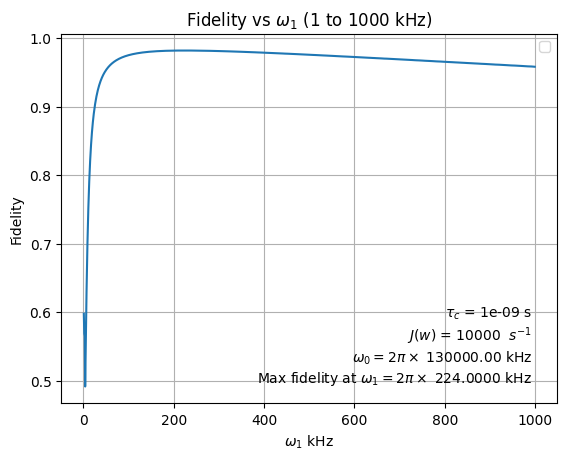

In [373]:
def plot_fidelity_range(w1_l, fidelity_matrix, w1_start, w1_end, fac):
    mask = (w1_l >= w1_start * 2 * np.pi * fac) & (w1_l <= w1_end * 2 * np.pi * fac)
    w1_l_range = w1_l[mask]
    fidelity_range = fidelity_matrix[mask]

    fig = plt.figure()
    plt.plot(w1_l_range / (2 * np.pi * fac), fidelity_range)
    plt.xlabel('$\\omega_1$ kHz')
    plt.ylabel('Fidelity')
    plt.title(f'Fidelity vs $\\omega_1$ ({w1_start} to {w1_end} kHz)')
    plt.savefig('fielity_dw1_0.01.png')
    plt.legend()
    plt.grid(True)
    # Add text annotation with best result in the bottom-right corner
    plt.text(0.95, 0.00,f'$\\tau_c$ = {tau_c} s\n'
                     f'$J(w)$ = {jw}  $s^{{-1}}$\n'
                     f'$\\omega_0 = 2 \\pi \\times$ {w0 / (2 * np.pi * fac):.2f} kHz\n'
                     f'Max fidelity at $\\omega_1 =2 \\pi \\times$ {max_w1 / (2 * np.pi * fac):.4f} kHz\n',
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='bottom', horizontalalignment='right')

    plt.show()

# Example usage:

plot_fidelity_range(w1_l, fidelity_matrix, 1, 1000, fac)